================================================================================
### Prepare tokenized dataset for BERT / RoBERTa fine-tuning
================================================================================

In [1]:
#Libraries
import os
import re
import random
import numpy as np
import pandas as pd
import torch

from datasets import Dataset
from transformers import AutoTokenizer
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns


# Seed
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# path
path = "C:/Users/diego/Desktop/multimodal-argmining"


# Model
MODEL_NAME = "roberta-base" 

c:\Users\diego\anaconda3\envs\multimodal\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# Load Dataset
train_path = f"{path}/data/gun_control_train.csv"
dev_path   = f"{path}/data/gun_control_dev.csv"

train_df = pd.read_csv(train_path)
print(f"Train dataset loaded: {train_df.shape}")


train_df.head()

Train dataset loaded: (923, 6)


,tweet_id,tweet_url,tweet_text,stance,persuasiveness,split
0,1372936384034447366,https://t.co/FpkVZ8ESy0,More Asian-Americans Are Buying Guns For Prote...,oppose,no,train
1,1327310308260667393,https://t.co/KrJTpJR3Ke,"""I will protect your Bill of Rights. Gun contr...",oppose,no,train
2,1334523148692312065,https://t.co/hBAV1pPCY9,#guns #2A 6-Time Olympic Shooting Medalist Say...,oppose,no,train
3,1324087921641721856,https://t.co/LfIzR6iPA3,Congratulations @ForHD65 on your victory! \n\n...,support,no,train
4,1313162243035607040,https://t.co/MZyeIP6Mtx,Dr. Cindy Banyai supports common sense gun saf...,support,no,train


In [3]:
#Label Mapping & Basic Filtering

#mapping
label2id = {"oppose": 0, "support": 1}
id2label = {v: k for k, v in label2id.items()}

#labels
train_df = train_df[train_df["stance"].isin(label2id.keys())].copy()
train_df["label"] = train_df["stance"].map(label2id)

print(train_df["label"].value_counts())

label
1    475
0    448
Name: count, dtype: int64


In [4]:
# Minimal Text Cleaning

# We apply only minimal preprocessing
# Heavy cleaning like stemming or stopword removal is not adviced before tokenization.

def minimal_clean(text):
    text = str(text)
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)   
    text = re.sub(r"@\w+", "", text)                      
    text = re.sub(r"\s+", " ", text).strip()              
    return text

train_df["tweet_text"] = train_df["tweet_text"].apply(minimal_clean)
train_df["tweet_text"].head()


0    More Asian-Americans Are Buying Guns For Prote...
1    "I will protect your Bill of Rights. Gun contr...
2    #guns #2A 6-Time Olympic Shooting Medalist Say...
3    Congratulations on your victory! We’re proud t...
4    Dr. Cindy Banyai supports common sense gun saf...
Name: tweet_text, dtype: object

In [5]:
# Load Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
print(f"Tokenizer loaded: {MODEL_NAME}")

Tokenizer loaded: roberta-base


C:\Users\diego\AppData\Local\Temp\ipykernel_25304\3399908218.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


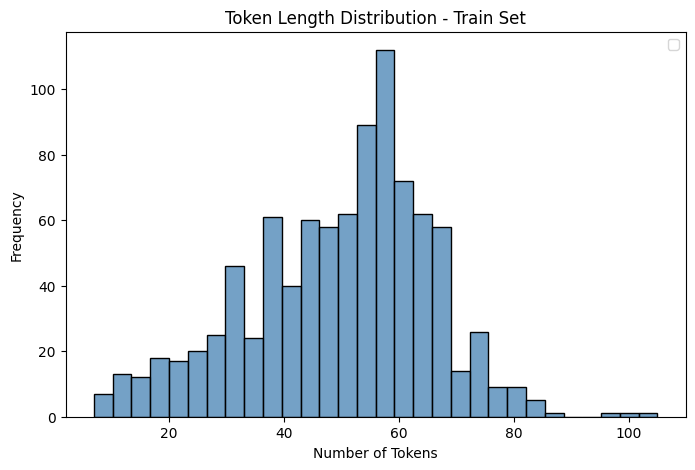

In [10]:
# Tokenization

def token_len(text):
    return len(tokenizer.encode(text, add_special_tokens=True))

train_token_lens = [token_len(t) for t in train_df["tweet_text"].tolist()]


# Plot token length distribution
plt.figure(figsize=(8,5))
sns.histplot(train_token_lens, bins=30, kde=False, color="steelblue")
plt.title("Token Length Distribution - Train Set")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.legend()
plt.show()

#max_length 
MAX_LEN = np.max(train_token_lens)

In [15]:
#Tokenization per Batch
def tokenize_batch(batch):
    return tokenizer(batch["tweet_text"],
                      padding="max_length",
                        truncation=True,
                          max_length=MAX_LEN)

# DataFrame to HF Dataset
hf_train_ds = Dataset.from_pandas(train_df[["tweet_id", "tweet_text", "label"]])
hf_train_ds = hf_train_ds.map(tokenize_batch, batched=True, batch_size=64)
hf_train_ds

Map: 100%|██████████| 923/923 [00:00<00:00, 2485.55 examples/s]


Dataset({
    features: ['tweet_id', 'tweet_text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 923
})

In [16]:
#Dataset Format for PyTorch
hf_train_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
print(hf_train_ds)

Dataset({
    features: ['tweet_id', 'tweet_text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 923
})


In [18]:

#Save Tokenized Datasets and Tokenizer
tokenized_dir = f"{path}/tokenized/{MODEL_NAME.replace('/', '_')}_maxlen{MAX_LEN}"
os.makedirs(tokenized_dir, exist_ok=True)
hf_train_ds.save_to_disk(os.path.join(tokenized_dir, "train"))
tokenizer.save_pretrained(tokenized_dir)
print(f"Tokenized datasets and tokenizer saved to:\n{tokenized_dir}")

Saving the dataset (1/1 shards): 100%|██████████| 923/923 [00:00<00:00, 36000.10 examples/s]


Tokenized datasets and tokenizer saved to:
C:/Users/diego/Desktop/multimodal-argmining/tokenized/roberta-base_maxlen105


In [19]:
print("Preprocessing and tokenization completed successfully.")

Preprocessing and tokenization completed successfully.
